# Cell2Cell Group Assignment
*Class*: Marketing Analytics (EWMBA263 -1)  
*Team*: Albert Deng, Peter Pang, Alex Im, and DJ Prahladka

## 0. Data Initialization

Initialize CSV data

In [127]:
import pandas
import shared.mba263 as mba263
import matplotlib.pyplot as plt
import numpy as np

data = pandas.read_csv('shared/cell2cell.csv')
data.head(10)

,customer,calibrat,churn,churndep,revenue,mou,recchrge,directas,overage,roam,...,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
0,1000002,0,0,NaN,57.492500,482.75,37.424999,0.2475,22.75,0.000000,...,0,0,1,0,0,5,0,0,149.989990,0
1,1000006,0,0,NaN,82.275002,1312.25,75.000000,1.2375,0.00,0.000000,...,0,1,0,0,0,6,0,0,9.989998,0
2,1000010,0,0,NaN,31.662500,25.50,29.990000,0.2475,0.00,0.000000,...,0,0,1,0,0,9,0,0,29.989990,0
3,1000011,0,0,NaN,62.127499,97.50,65.985001,2.4750,0.00,0.000000,...,0,1,0,0,0,6,0,0,29.989990,0
4,1000014,0,0,NaN,25.225000,2.50,25.000000,0.0000,0.00,0.000000,...,0,1,0,0,0,7,0,0,29.989990,0
5,1000015,0,0,NaN,212.515000,1971.50,84.989998,2.2275,249.50,35.497501,...,0,1,0,0,0,3,0,0,79.989990,0
6,1000016,0,0,NaN,42.564999,270.50,37.480000,0.2475,6.00,0.000000,...,0,0,1,0,0,1,0,0,29.989990,0
7,1000018,0,0,NaN,35.590000,153.00,29.990000,0.0000,16.00,0.000000,...,0,0,1,0,0,4,0,0,199.989990,0
8,1000019,0,0,NaN,55.270000,1212.75,49.990002,0.7425,0.00,1.285000,...,0,0,1,0,0,3,0,0,9.989998,0
9,1000020,0,0,NaN,50.965000,162.00,69.989998,0.0000,2.50,0.000000,...,0,1,0,0,0,1,0,0,9.989998,0


Read in variable documentation

In [128]:
# Read supplementation documentation and statistics about each variable
docs = pandas.read_excel('Cell2Cell_Data_Documentation.xlsx', sheet_name='Sheet1', usecols='A:B,D:I', skiprows=range(0, 5), header=0)
docs.head()

,Position,Variable Name,Variable Descriptiion,N,Minimum,Maximum,Mean,Standard Deviation
0,1,customer,Customer ID,71047,1.000001e+06,1099999.00,1.050487e+06,29199.114811
1,2,calibrat,Calibration sample = 1; Validation sample = 0;,71047,0.000000e+00,1.00,5.630076e-01,0.496018
2,3,churn,Churn between 31-60 days after obs_date,71047,0.000000e+00,1.00,2.900756e-01,0.453800
3,4,churndep,Churn (=missing for validation sample),40000,0.000000e+00,1.00,5.000000e-01,0.500006
4,5,revenue,Mean monthly revenue,70831,-6.167500e+00,1223.38,5.885280e+01,44.243583


## 1. Data Selection and Analysis
### a) Variable Definition

In [129]:
def classify_variables(variables):
    continuous = []
    decile = []
    indicator = []

    for variable in variables:
        if data[variable].max() == 1 and data[variable].min() == 0:
            indicator.append(variable)
        elif data[variable].max() == 9 and data[variable].min() == 0:
            decile.append(variable)
        else:
            continuous.append(variable)
    return continuous, decile, indicator

all_variables = ['revenue','mou','recchrge','directas','overage','roam','changem','changer','dropvce','blckvce','unansvce','custcare','threeway','mourec','outcalls','incalls','peakvce','opeakvce','dropblk','callfwdv','callwait','months','uniqsubs','actvsubs','phones','models','eqpdays','age1','age2','children','credita','creditaa','prizmrur','prizmub','prizmtwn','refurb','webcap','truck','rv','occprof','occcler','occcrft','occstud','occhmkr','occret','occself','ownrent','marryun','marryyes','mailord','mailres','mailflag','travel','pcown','creditcd','retcalls','retaccpt','newcelly','newcelln','refer','incmiss','income','mcycle','setprcm','setprc','retcall']

# Drop perfectly correlated variables
# Drop 

# Classify variable types
continuous_variables, decile_variables, indicator_variables = classify_variables(all_variables)

### b) Exploratory Data Analysis
Define functions to classify whether a variable has a significant difference in predicting churn

In [130]:
# Define a function that checks whether the distribution of a variable is significantly different between two groups
def is_indicator_significant(dataset, predict, variable, threshold):
    chi2, p = mba263.chi2(dataset[predict], dataset[variable])
    # Return whether the p-value is below the threshold
    return p < threshold

def sort_indicators_by_p(dataset, predict, variables):
    p_values = []
    for variable in variables:
        p = mba263.chi2(dataset[predict], dataset[variable])[1]
        p_values.append(p)
    return pandas.DataFrame({'variable': variables, 'p': p_values}).sort_values('p')['variable'].values

In [131]:
test = data.loc[data['calibrat'] == 1]

# Filter the indicator_variables list to only include significant variables
sig_indicator_variables = [variable for variable in indicator_variables 
                           if is_indicator_significant(test, 'churndep', variable, 0.03)]
sig_indicator_variables = sort_indicators_by_p(test, 'churndep', sig_indicator_variables)
print(sig_indicator_variables)

['retcall' 'webcap' 'creditaa' 'setprcm' 'refurb' 'mailres' 'mailord'
 'marryun' 'credita' 'incmiss' 'ownrent' 'creditcd' 'newcelly' 'prizmtwn']


In [132]:
test.groupby('newcelly')['churn'].mean()

newcelly
0    0.503315
1    0.486147
Name: churn, dtype: float64

### c) Variable Selection

In [133]:
# Append sig_indicator_variables, decile_variables, and continuous variables together
selected_variables = np.concatenate((sig_indicator_variables, decile_variables, continuous_variables), axis=None)

## 2. Run analyses
### a) Build model

Define function that will tune model

In [134]:
data_test = data.copy()
tr, te = data[data['calibrat'] == 1], data[data['calibrat'] == 0]

mod = mba263.logit(tr['churndep'], tr[all_variables])
tr['pred'] = mod.predict(tr[all_variables])
tr['churndep'] = np.where(tr['pred'] > 0.5, 1, 0)

te['pred'] = mod.predict(te[all_variables])
te['churndep'] = np.where(te['pred'] > 0.5, 1, 0)

# (te.loc[te['churndep'] == 1]['churn'].mean() / te['churn'].mean()) * 100
# tr[['pred', 'churn', 'churndep']].head()
te.groupby('churndep')['churn'].mean()


Optimization terminated successfully.
         Current function value: 0.671533
         Iterations 5


churndep
0    0.014338
1    0.027750
Name: churn, dtype: float64

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

# Create a custom scoring function based on lift calculations
def exp_churn_scoring(test_set, predict, actual):
   test_set['pred'] = predict
   pred_rate = test_set.loc[test_set['pred'] == 1]['churn'].mean()
   actual_rate = np.mean(actual)
   return (pred_rate / actual_rate)*100
    
# A function to identify the best parameter(s) for a model tested using cross-validation
def tune_hyperparameters(train_dataset, predict, variables, threshold, param_grid, mod_type):
   # Set up the KFold object
   kf = KFold(n_splits=5, shuffle=True, random_state=0)
   best_score = -np.inf
   
   # Loop over the parameter grid for logistic regressions and neural networks
   if mod_type == 'logit_reg' or mod_type == 'neural_network':
      for a in param_grid['a']:
         scores = []
         
         # Loop over the cross-validation folds
         for train_index, test_index in kf.split(train_dataset):

            # Split the dataset
            x_train, x_test = train_dataset.iloc[train_index][variables], train_dataset.iloc[test_index][variables]
            y_train, y_test = train_dataset.iloc[train_index][predict], train_dataset.iloc[test_index][predict]

            # Fit and run the model
            if mod_type == 'logit_reg':
               model = mba263.logit_reg(y_train, x_train, a)
            elif mod_type == 'neural_network':
               model = mba263.neural_network(y_train, x_train, a)
               
            # Score results
            y_pred = np.where(model.predict(x_test) > threshold, 1, 0)
            scores.append(exp_churn_scoring(train_dataset.iloc[test_index], y_pred, y_test))

         # Compute the average score
         mean_score = np.mean(scores)

         # If the score is better, record the parameter
         if mean_score > best_score:
            best_score = mean_score
            best_param = {'a': a}
         
         # Reset scores
         scores.clear()

   # Return the best parameter
   return best_param

In [136]:
### A function to run a logistic regression, a logistic regression w/ regularization, 
### a neural network, and a random forest
### Function adds two columns, p for probability and res if selected for targeting
def run_ml_models(dataset, actual, variables, threshold):
    df = dataset.copy()

    # Split dataset into train and test based on whether calibrat = 0 or 1
    train, test = data[data['calibrat'] == 1], data[data['calibrat'] == 0]

    ### Use a logistic regression with regularization
    ### ------------------------------------------------
    logit_reg_param_grid = {'a': [0, 0.01, 0.1, 0.5, 1, 3]}
    best_param_logit_reg = 0
    # best_param_logit_reg = tune_hyperparameters(
    #     train, actual, variables, threshold, logit_reg_param_grid, 'logit_reg')

    # Use the tuned parameter to predict
    # result_logit_reg = mba263.logit_reg(train[actual], train[variables], best_param_logit_reg['a'])
    result_logit_reg = mba263.logit(train[actual], train[variables])

    train['p_logr'] = result_logit_reg.predict(train[variables])
    train['res_logr'] = np.where(train['p_logr'] > threshold, 1, 0)
    test['p_logr'] = result_logit_reg.predict(test[variables])
    test['res_logr'] = np.where(test['p_logr'] > threshold, 1, 0)

    # Rename churn to actuals
    train['actual_res'] = train['churn']
    test['actual_res'] = test['churn']

    # Return three items, the results on the test dataset, the results on the training, and the models
    return [test[['customer', 'p_logr','actual_res', 'res_logr',]],
            train[['customer', 'p_logr','actual_res', 'res_logr',]], 
               [result_logit_reg],
               [best_param_logit_reg]]

Tune and run the logistic regression based on the dataset

In [137]:
predictions, actuals, model, params = run_ml_models(data, "churndep", all_variables, 0.6)

Optimization terminated successfully.
         Current function value: 0.671533
         Iterations 5


## 3. Evaluation
### a) Evaluate model characteristics
Print parameters, coefficients, and odds for the resulting model

In [138]:
from IPython.display import display
def print_params(params):
    if params[0] != 0:
        print("Logistic Regression Regularization Parameter: {}".format(params[0]['a']))

# Print the coefficients for the logistic regressions
def print_coefs(models):
    display(models[0].summary())

print_params(params)
print_coefs(model)

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Mba263Logit Regression Results                        
==============================================================================
Dep. Variable:               churndep   No. Observations:                38941
Model:                    Mba263Logit   Df Residuals:                    38874
Method:                           MLE   Df Model:                           66
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:                 0.03117
Time:                        17:20:03   Log-Likelihood:                -26150.
converged:                       True   LL-Null:                       -26992.
Covariance Type:            nonrobust   LLR p-value:                6.012e-308
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1497      0.095      1.571      0.116      -0.037       0.336
revenue        0.0020      0.001      2.460      0.014       0.000       0.004
mou           -0.0003   4.96e-05     -5.657      0.000      -0.000      -0.000
recchrge      -0.0031      0.001     -3.513      0.000      -0.005      -0.001
directas      -0.0012      0.006     -0.201      0.840      -0.013       0.010
overage        0.0008      0.000      2.711      0.007       0.000       0.001
roam           0.0071      0.002      3.436      0.001       0.003       0.011
changem       -0.0005   5.35e-05     -9.194      0.000      -0.001      -0.000
changer        0.0023      0.000      6.247      0.000       0.002       0.003
dropvce        0.0113      0.007      1.563      0.118      -0.003       0.026
blckvce        0.0064      0.007      0.895      0.371      -0.008       0.020
unansvce       0.0009      0.000      2.058      0.040    4.38e-05       0.002
custcare      -0.0060      0.003     -2.331      0.020      -0.011      -0.001
threeway      -0.0303      0.011     -2.691      0.007      -0.052      -0.008
mourec         0.0001      0.000      1.018      0.309      -0.000       0.000
outcalls       0.0011      0.001      1.894      0.058   -3.87e-05       0.002
incalls       -0.0031      0.001     -2.937      0.003      -0.005      -0.001
peakvce       -0.0007      0.000     -3.058      0.002      -0.001      -0.000
opeakvce      -0.0002      0.000     -0.783      0.434      -0.001       0.000
dropblk       -0.0031      0.007     -0.442      0.658      -0.017       0.011
callfwdv      -0.0026      0.023     -0.114      0.909      -0.048       0.043
callwait       0.0021      0.003      0.664      0.507      -0.004       0.008
months        -0.0213      0.002    -10.652      0.000      -0.025      -0.017
uniqsubs       0.1844      0.020      9.225      0.000       0.145       0.224
actvsubs      -0.2057      0.028     -7.372      0.000      -0.260      -0.151
phones         0.0487      0.018      2.678      0.007       0.013       0.084
models         0.0138      0.028      0.495      0.621      -0.041       0.068
eqpdays        0.0014   7.47e-05     19.309      0.000       0.001       0.002
age1          -0.0033      0.001     -3.787      0.000      -0.005      -0.002
age2          -0.0012      0.001     -1.718      0.086      -0.003       0.000
children       0.0946      0.028      3.359      0.001       0.039       0.150
credita       -0.1781      0.036     -5.016      0.000      -0.248      -0.108
creditaa      -0.3626      0.035    -10.488      0.000      -0.430      -0.295
prizmrur       0.0665      0.050      1.342      0.180      -0.031       0.164
prizmub       -0.0396      0.024     -1.624      0.104      -0.087       0.008
prizmtwn       0.0462      0.031      1.470      0.142      -0.015       0.108
refurb         0.2340      0.032      7.323      0.000       0.171       0.297
webcap        -0.1561      0.038     -4.157      0.000      -0.230      -0.083
tr

### b) Analyze Lift
Calculate overall model lift based on test dataset.

In [139]:
test_rate = predictions['actual_res'].mean()
selected_test_rate = predictions.loc[predictions['res_logr'] == 1]['actual_res'].mean()
print("Lift: {:.2f}%".format((selected_test_rate / test_rate) * 100))

Lift: 174.70%


Calculate lift by deciles and construct a lift chart.

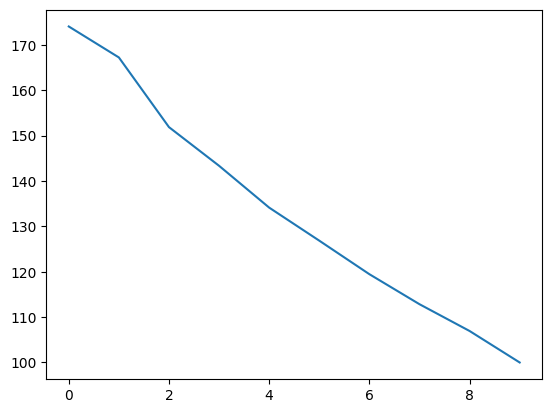

In [140]:
plt.plot(mba263.lift(predictions['actual_res'], predictions['p_logr']))


### c) Model Analysis
Review the economic importance of each predictor variable. Start with the odds ratios.

In [141]:
# Print the odds ratios for each logistic regression
def print_odds(models):
    print("Logistic Regression w/ Regularization Odds Ratios")
    display(mba263.odds_ratios(models[0]))

print_odds(model)

Logistic Regression w/ Regularization Odds Ratios


,Odds ratios,std err,z,P>|z|,[0.025,0.975]
revenue,1.001965,0.000800,2.457744,0.014,1.000414,1.003517
mou,0.999719,0.000050,5.657881,0.000,0.999623,0.999815
recchrge,0.996882,0.000886,3.518808,0.000,0.995164,0.998601
directas,0.998805,0.005932,0.201471,0.840,0.987298,1.010312
overage,1.000761,0.000281,2.710145,0.007,1.000216,1.001305
roam,1.007116,0.002078,3.424242,0.001,1.003085,1.011148
changem,0.999508,0.000053,9.196371,0.000,0.999404,0.999612
changer,1.002306,0.000370,6.239374,0.000,1.001589,1.003023
dropvce,1.011402,0.007337,1.554203,0.120,0.997170,1.025635
blckvce,1.006423,0.007203,0.891658,0.373,0.992448,1.020398


Normalize them against each variable's standard deviation

In [142]:
# Avoid truncation
pandas.set_option('display.max_rows', None)

# Retrieve odds and standard deviations
odds = mba263.odds_ratios(model[0])
x_std = docs[['Variable Name', 'Standard Deviation']]

# Join odds ratios against standard deviations
joined = odds.merge(x_std, left_index=True, right_on='Variable Name')

# Calculate normalized odds
joined['norm_odds'] = np.power(joined['Odds ratios'], joined['Standard Deviation'])

# Calculate magnitude (reverse direction for negative odds)
joined['mag_odds'] = joined['norm_odds']

# set mag_odds to 1/mag_odds if norm_odds is less than 1
joined.loc[joined['mag_odds'] < 1, 'mag_odds'] = 1 / joined['norm_odds']
joined = joined.sort_values('mag_odds', ascending=False)

joined[['Variable Name', 'mag_odds']]

,Variable Name,mag_odds
30,eqpdays,1.442839
26,uniqsubs,1.232051
25,months,1.231607
5,mou,1.160552
69,retcall,1.154781
27,actvsubs,1.145435
10,changem,1.133826
35,creditaa,1.129021
12,dropvce,1.107506
11,changer,1.093412
